# Linear Models
## Dream Team - ORIE 4741 Project
### Darren Chang

In [2]:
using CSV, Plots, DataFrames, Statistics, LinearAlgebra, GLM, Random

Load data from CSV.

In [22]:
df = CSV.read("weekly_ff.csv")

feature_names = names(df)
for i in 1:56
    println(string(i), "\t", string(feature_names[i]), "\t\t\t", string(eltype(df[!, i])))
end

1	week			Int64
2	Player			String
3	Pos			String
4	team1			String
5	PassingYds			Int64
6	PassingTD			Int64
7	Int			Int64
8	PassingAtt			Int64
9	Cmp			Int64
10	RushingAtt			Int64
11	RushingYds			Int64
12	RushingTD			Int64
13	Rec			Int64
14	Tgt			Int64
15	ReceivingYds			Int64
16	ReceivingTD			Int64
17	FL			Int64
18	PPRFantasyPoints			Float64
19	StandardFantasyPoints			Float64
20	HalfPPRFantasyPoints			Float64
21	type			String
22	game_id			String
23	team2			String
24	season			String
25	team1_score			Int64
26	team2_score			Int64
27	PassingYds_cum			Float64
28	PassingTD_cum			Float64
29	Int_cum			Float64
30	PassingAtt_cum			Float64
31	Cmp_cum			Float64
32	RushingAtt_cum			Float64
33	RushingYds_cum			Float64
34	RushingTD_cum			Float64
35	Rec_cum			Float64
36	Tgt_cum			Float64
37	ReceivingYds_cum			Float64
38	ReceivingTD_cum			Float64
39	FL_cum			Float64
40	team1_score_cum			Float64
41	team2_score_cum			Float64
42	PassingYds_prev			Int64
43	PassingTD_prev			Int64
44	Int_prev			Int64
45	Passing

Train/test split with proportion of training data = 0.8

In [23]:
Random.seed!(0)

df = df[.!(ismissing.(df[!, :StandardFantasyPoints])), :]
df = df[shuffle(1:end), :]

train_proportion = 0.8
n = size(df, 1)
println("Size of dataset: ", string(n))

ntrain = convert(Int, round(train_proportion*n))

target = df[:, [:StandardFantasyPoints, :PPRFantasyPoints, :HalfPPRFantasyPoints]]

train_x = df[1:ntrain, Not([:StandardFantasyPoints, :PPRFantasyPoints, :HalfPPRFantasyPoints])]
test_x = df[ntrain:end, Not([:StandardFantasyPoints, :PPRFantasyPoints, :HalfPPRFantasyPoints])]

train_std = target[1:ntrain, :StandardFantasyPoints]
test_std = target[ntrain:end, :StandardFantasyPoints]

train_ppr = target[1:ntrain, :PPRFantasyPoints]
test_ppr = target[ntrain:end, :PPRFantasyPoints]

train_half = target[1:ntrain, :HalfPPRFantasyPoints]
test_half = target[ntrain:end, :HalfPPRFantasyPoints]

# let's take a look
train_x

Size of dataset: 52744


,week,Player,Pos,team1,PassingYds,PassingTD,Int,PassingAtt
,Int64,String,String,String,Int64,Int64,Int64,Int64
1,12,Marcedes Lewis,TE,JAX,0,0,0,0
2,13,Aaron Jones,RB,GNB,0,0,0,0
3,12,Brett Favre,QB,MIN,271,3,0,31
4,9,Jamize Olawale,FB,OAK,0,0,0,0
5,2,Kyler Murray,QB,ARI,324,3,1,44
6,15,Legedu Naanee,WR,CAR,0,0,0,0
7,3,Lorenzo Booker,RB,MIN,0,0,0,0
8,8,Chris Givens,WR,BAL,0,0,0,0
9,11,Lavelle Hawkins,WR,TEN,0,0,0,0


Convert string data to float and to integer (Julia thinks that game_id and season are string, although both can be expressed as integers/floats).

In [24]:
function string_to_float(str)
    try
        parse(Float64, str)
    catch
       0.0
    end
end

string_to_float (generic function with 1 method)

In [25]:
function string_to_int(str)
    try
        parse(Int64, str)
    catch
        0
    end
end

string_to_int (generic function with 1 method)

In [26]:
train_x[:game_id] = string_to_float.(train_x[:game_id])
test_x[:game_id] = string_to_float.(test_x[:game_id])

10550-element Array{Float64,1}:
 2.013102703e9
 2.014101906e9
 2.012091611e9
 2.017102908e9
 2.019090805e9
 2.013112409e9
 2.017091003e9
 2.018112504e9
 2.014091406e9
 0.0
 2.0111211e9
 0.0
 2.013092906e9
 ⋮
 2.010100307e9
 2.017102207e9
 2.018111806e9
 2.013111004e9
 2.014091401e9
 2.0151227e9
 2.018101402e9
 2.013102003e9
 2.013122206e9
 2.0141013e9
 2.0151217e9
 2.010112108e9

In [27]:
train_x[:season] = string_to_int.(train_x[:season])
test_x[:season] = string_to_int.(test_x[:season])

10550-element Array{Int64,1}:
 2013
 2014
 2012
 2017
 2019
 2013
 2017
 2018
 2014
    0
 2011
    0
 2013
    ⋮
 2010
 2017
 2018
 2013
 2014
 2015
 2018
 2013
 2013
 2014
 2015
 2010

Create a real-valued subset.

In [28]:
labels_real = [
    :PassingYds_cum,
    :PassingTD_cum,
    :Int_cum,
    :PassingAtt_cum,
    :Cmp_cum,
    :RushingAtt_cum,
    :RushingYds_cum,
    :RushingTD_cum,
    :Rec_cum,
    :Tgt_cum,
    :ReceivingYds_cum,
    :ReceivingTD_cum,
    :FL_cum,
    :team1_score_cum,
    :team2_score_cum,
    :PassingYds_prev,
    :PassingTD_prev,
    :Int_prev,
    :PassingAtt_prev,
    :Cmp_prev,
    :RushingAtt_prev,
    :RushingYds_prev,
    :RushingTD_prev,
    :Rec_prev,
    :Tgt_prev,
    :ReceivingYds_prev,
    :ReceivingTD_prev,
    :FL_prev,
    :team1_score_prev,
    :team2_score_prev 
]

train_real = train_x[labels_real]
test_real = test_x[labels_real]

,PassingYds_cum,PassingTD_cum,Int_cum,PassingAtt_cum,Cmp_cum,RushingAtt_cum
,Float64,Float64,Float64,Float64,Float64,Float64
1,321.857,1.85714,0.714286,45.1429,28.7143,1.28571
2,0.0,0.0,0.0,0.0,0.0,0.333333
3,0.0,0.0,0.0,0.0,0.0,17.0
4,0.0,0.0,0.0,0.0,0.0,14.75
5,0.0,0.0,0.0,0.0,0.0,0.0
6,198.857,1.14286,0.714286,28.5714,17.7143,2.85714
7,0.0,0.0,0.0,0.0,0.0,3.0
8,0.0,0.0,0.0,0.0,0.0,0.1
9,8.0,0.0,0.0,1.0,1.0,3.0


Convert the categorical labels into one-hot encoded data. This is for the team of the player (team1) and the team of the opponent (team2) as well as the position. 

In [32]:
cat_labels = [
  :team1,
  :team2,
  :Pos
]

#Sets of all categories in a particular column
cats_sets = [unique(df[:, label]) for label in cat_labels]

"Computes a onehot vector for every entry in column given a set of categories cats"
function onehot(column, cats=unique(column))
    len = length(column)
    len_val = length(cats)
    result = zeros(len, len_val)
    
    for i=1:len
        string=column[i]
        for j=1:len_val
            if contains(string, cats[j])
                result[i,j]=1
            end
        end
    end
    result
end

# [onehot(train_x[:, cat_labels[i]], cats_sets[i]) for i in 1:size(cat_labels, 1)]

train_cat_vals = hcat([onehot(train_x[:, cat_labels[i]], cats_sets[i]) for i in 1:size(cat_labels, 1)]...)
test_cat_vals = hcat([onehot(test_x[:, cat_labels[i]], cats_sets[i]) for i in 1:size(cat_labels, 1)]...)

10550×159 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  

In [35]:
Xtrain = replace(hcat(convert(Matrix, train_real), train_cat_vals, ones(nrow(train_x))), NaN=>0)
Xtest = replace(hcat(convert(Matrix, test_real), test_cat_vals, ones(nrow(test_x))), NaN=>0)

10550×190 Array{Float64,2}:
 321.857  1.85714  0.714286  45.1429  …  0.0  0.0  0.0  0.0  0.0  0.0  1.0
   0.0    0.0      0.0        0.0        0.0  0.0  0.0  0.0  0.0  0.0  1.0
   0.0    0.0      0.0        0.0        0.0  0.0  0.0  0.0  0.0  0.0  1.0
   0.0    0.0      0.0        0.0        0.0  0.0  0.0  0.0  0.0  0.0  1.0
   0.0    0.0      0.0        0.0        0.0  0.0  0.0  0.0  0.0  0.0  1.0
 198.857  1.14286  0.714286  28.5714  …  0.0  0.0  0.0  0.0  0.0  0.0  1.0
   0.0    0.0      0.0        0.0        0.0  0.0  0.0  0.0  0.0  0.0  1.0
   0.0    0.0      0.0        0.0        0.0  0.0  0.0  0.0  0.0  0.0  1.0
   8.0    0.0      0.0        1.0        0.0  0.0  0.0  0.0  0.0  0.0  1.0
   0.0    0.0      0.0        0.0        0.0  0.0  0.0  0.0  0.0  0.0  1.0
   0.0    0.0      0.0        0.0     …  0.0  0.0  0.0  0.0  0.0  0.0  1.0
   0.0    0.0      0.0        0.0        0.0  0.0  0.0  0.0  0.0  0.0  1.0
   0.0    0.0      0.0        0.0        0.0  0.0  0.0  0.0  0.0  0.0  1

In [36]:
"""This function computes the mean squared error."""
function MSE(y, pred)
    error = (y.-pred).^2
    mse = sum(error[:, 1])/size(error, 1)
    return mse
end

MSE

In [44]:
"""This completed function plots the main diagonal
for a predicted vs true plot with perfect predictions
all data lies on this line"""
function plotDiagonal(xmin, xmax)
    xsamples = [xmin, xmax]
    plot!(xsamples, xsamples, color=:black)
end

"""This completed helper function plots x vs, y and labels the axes."""
function plotdata(x,y,xname, yname; margin=.05, plotDiag=true, zeromin=false)
    scatter(x,y, label="data")
    xlabel!(xname)
    ylabel!(yname)
    range_y = maximum(y) - minimum(y)
    range_x = maximum(x) - minimum(x)
    if plotDiag
        plotDiagonal(minimum(x)-margin*range_x, maximum(x)+margin*range_x)
    end
    if zeromin
        ylims!((0.0,maximum(y)+margin*range_y))
        xlims!((0.0,maximum(x)+margin*range_x))
    else
        ylims!((minimum(y)-margin*range_y,maximum(y)+margin*range_y))
        xlims!((minimum(x)-margin*range_x,maximum(x)+margin*range_x))
    end
end

"""This completed function plots the predicted labels vs the actual labels
(We only plots the first 1000 points to avoid slow plots.)"""
function plot_pred_true(test_pred, test_y, max_points = 1000)
    plotdata(test_pred[1:max_points], test_y[1:max_points], "Predicted (Points)", "True (Points)", zeromin=true)
end

plot_pred_true

In [39]:
w = Xtrain \ train_std
train_pred = sum(w'.*Xtrain, dims = 2)
test_pred = sum(w'.*Xtest, dims = 2)

train_MSE = MSE(train_std, train_pred)
test_MSE = MSE(test_std, test_pred)

19.378000531598747

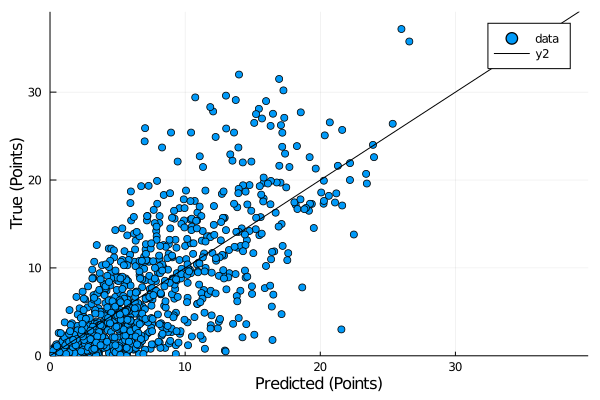

In [45]:
plot_pred_true(test_pred, test_std)